In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import folium
from IPython.display import display, HTML
from os.path import abspath
from darts import TimeSeries
from scipy.signal import periodogram
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LassoCV
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from scipy.ndimage import gaussian_filter1d
import xgboost as xgb

path_to_inflow = "../observations/wwtp.csv"
path_to_dmi_data = "../observations/dmi.csv"

inflow = pd.read_csv(abspath(path_to_inflow), parse_dates=True, index_col=0, sep=";")
inflow.index.name = "time"
inflow.index = inflow.index.tz_localize("Europe/Copenhagen", ambiguous="NaT").tz_convert("utc")

climate = pd.read_csv(abspath(path_to_dmi_data), parse_dates=True, index_col=0, sep=",")

horsens = inflow.merge(climate, left_index=True, right_index=True, how="inner")

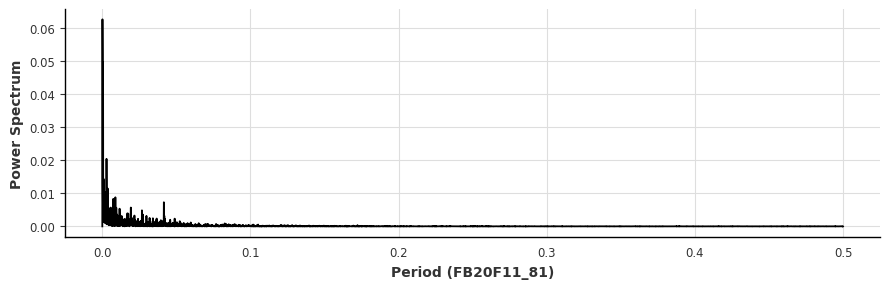

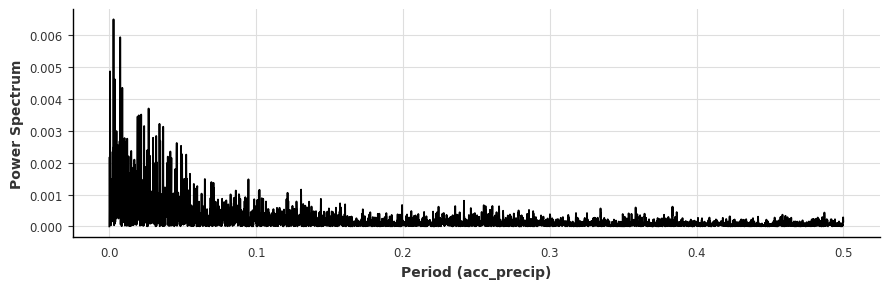

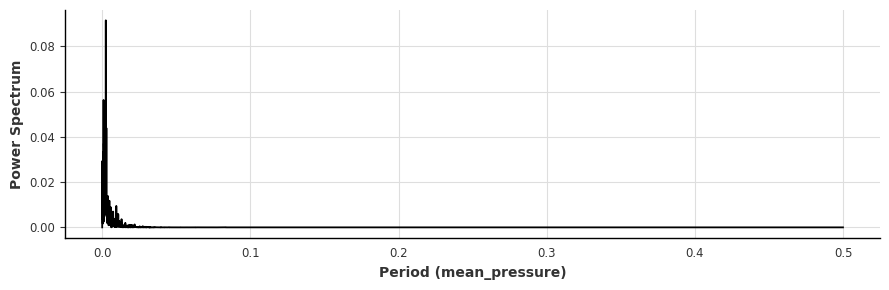

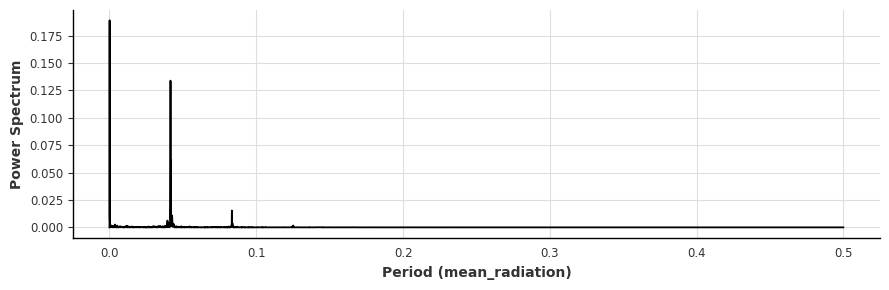

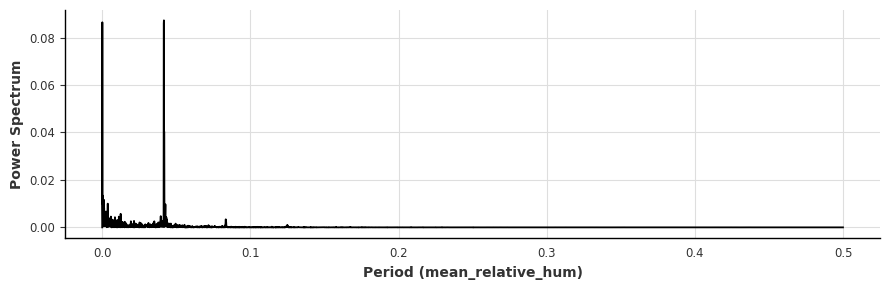

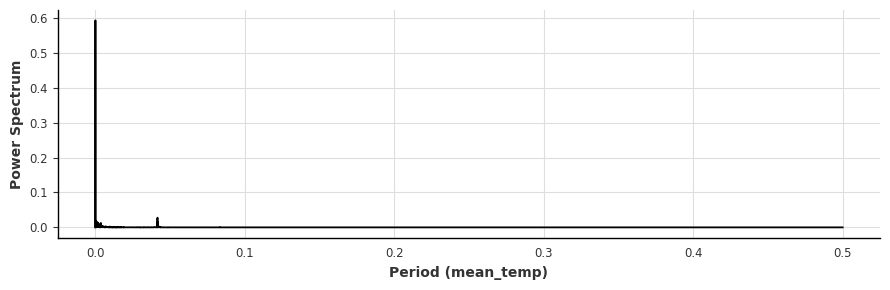

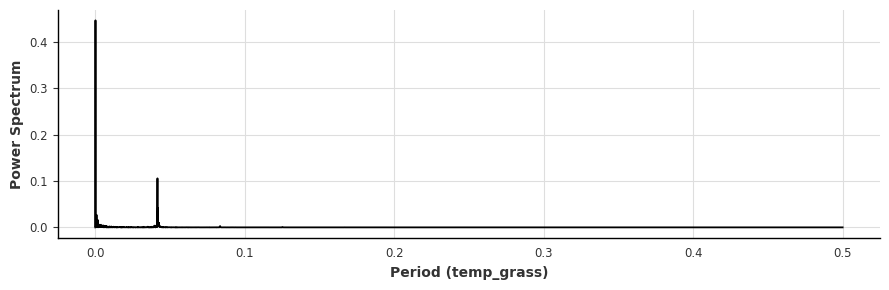

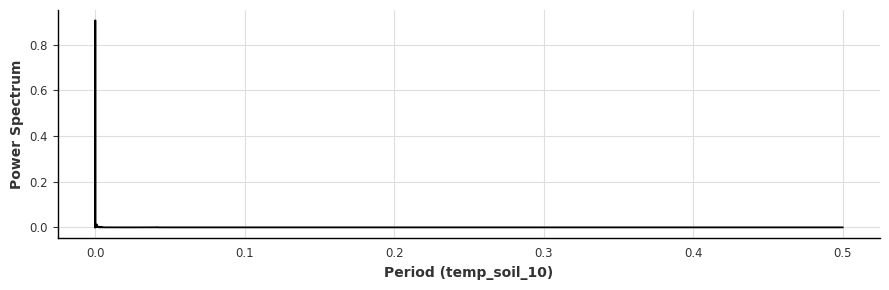

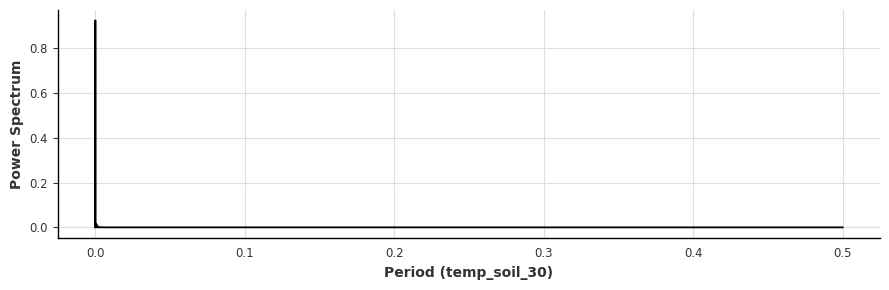

In [2]:
scaler = StandardScaler()
horsens_scaled = pd.DataFrame(scaler.fit_transform(horsens), columns=horsens.columns, index=horsens.index)

for feature in horsens_scaled.columns:
    f, Pxx = periodogram(horsens_scaled[feature].dropna(), fs=1.0, scaling="spectrum")
    g = sns.relplot(x=f, y=Pxx, kind="line", height=3, aspect=3)
    g.set_axis_labels(f"Period ({feature})", "Power Spectrum")


In [3]:
features_to_drop = ["temp_grass", "mean_radiation"]
horsens = horsens.drop(columns=features_to_drop)
horsens = horsens.fillna(method="ffill")
def add_fourier_terms(df, period=24):
    timestamps = (df.index - df.index[0]).total_seconds() / 3600  # Convert index to hours
    omega = 2 * np.pi / period
    df['fourier_sin'] = np.sin(omega * timestamps)
    df['fourier_cos'] = np.cos(omega * timestamps)
    return df

horsens = add_fourier_terms(horsens, period=24)

horsens = add_fourier_terms(horsens)


/tmp/ipykernel_450051/3006281431.py:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  horsens = horsens.fillna(method="ffill")


In [4]:
y = horsens["FB20F11_81"]
X = horsens.drop(columns=["FB20F11_81"])
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=X.index)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, shuffle=False)


In [5]:
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(f"Standard Model MAE: {mean_absolute_error(y_test, y_pred):.3f}")
print(f"Standard Model R² Score: {r2_score(y_test, y_pred):.3f}")


Standard Model MAE: 367.526
Standard Model R² Score: 0.469


In [6]:
y_smooth = gaussian_filter1d(y, sigma=5)
y_train_smooth, y_test_smooth = train_test_split(y_smooth, test_size=0.2, random_state=42, shuffle=False)
smooth_model = RandomForestRegressor(n_estimators=100, random_state=42)
smooth_model.fit(X_train, y_train_smooth)
y_pred_smooth = smooth_model.predict(X_test)
print(f"Smoothed Model MAE: {mean_absolute_error(y_test_smooth, y_pred_smooth):.3f}")
print(f"Smoothed Model R² Score: {r2_score(y_test_smooth, y_pred_smooth):.3f}")


Smoothed Model MAE: 329.042
Smoothed Model R² Score: 0.455


In [7]:

cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=42)
alphas = np.logspace(-4, 1, 100)
lasso = LassoCV(alphas=alphas, cv=cv, max_iter=5000, random_state=42)
lasso.fit(X_train, y_train)
selected_features = X_train.columns[lasso.coef_ != 0]
print(f"Selected features: {list(selected_features)}")
# drop temp_soil_10 due to multicollinearity
selected_features = selected_features.drop("temp_soil_10")


Selected features: ['acc_precip', 'mean_pressure', 'mean_relative_hum', 'mean_temp', 'temp_soil_10', 'temp_soil_30', 'fourier_sin', 'fourier_cos']


In [8]:
forecast_horizon = 24
gap_size = forecast_horizon + 1  

for step in range(1, forecast_horizon + 1):
    horsens[f'FB20F11_81_t+{step}'] = horsens['FB20F11_81'].shift(-step)

for step in range(1, forecast_horizon + 1):
    horsens[f'acc_precip_t+{step}'] = horsens['acc_precip'].shift(-step)

target_columns = [f'FB20F11_81_t+{step}' for step in range(1, forecast_horizon + 1)]

gap_index = int(len(horsens) * 0.8)
train_horsens = horsens.iloc[:gap_index - gap_size]
test_horsens = horsens.iloc[gap_index:]

train_horsens = train_horsens.dropna()
test_horsens = test_horsens.dropna()

X_train = train_horsens.drop(columns=['FB20F11_81'] + target_columns)
y_train = train_horsens[target_columns]

X_test = test_horsens.drop(columns=['FB20F11_81'] + target_columns)
y_test = test_horsens[target_columns]

scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)

xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=200, learning_rate=0.05, max_depth=6)
xgb_model.fit(X_train_scaled, y_train)

y_pred = xgb_model.predict(X_test_scaled)



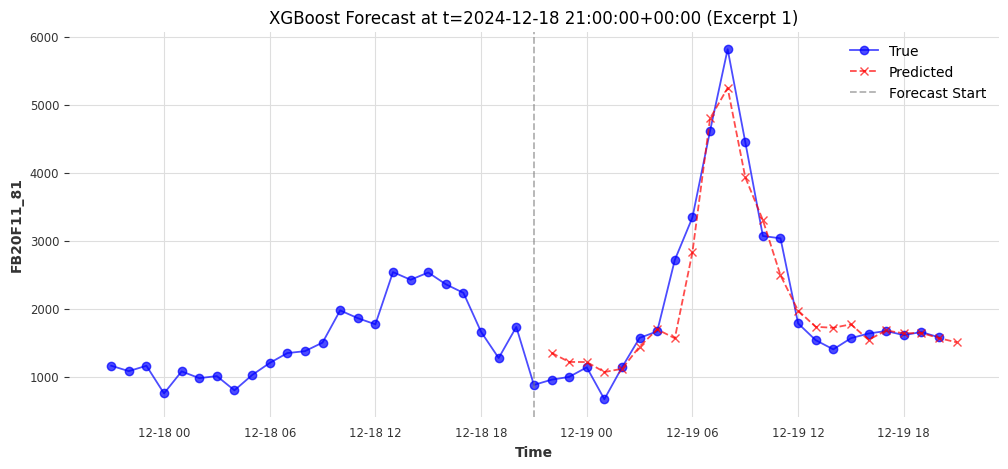

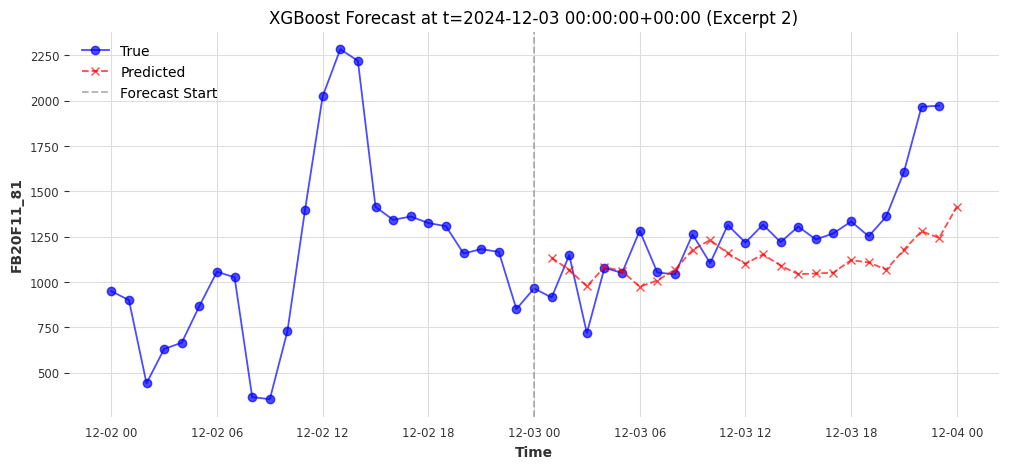

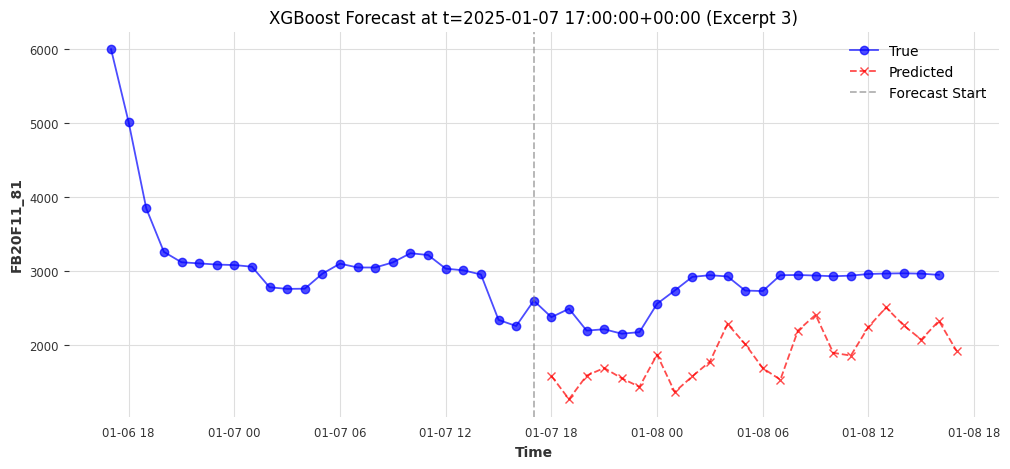

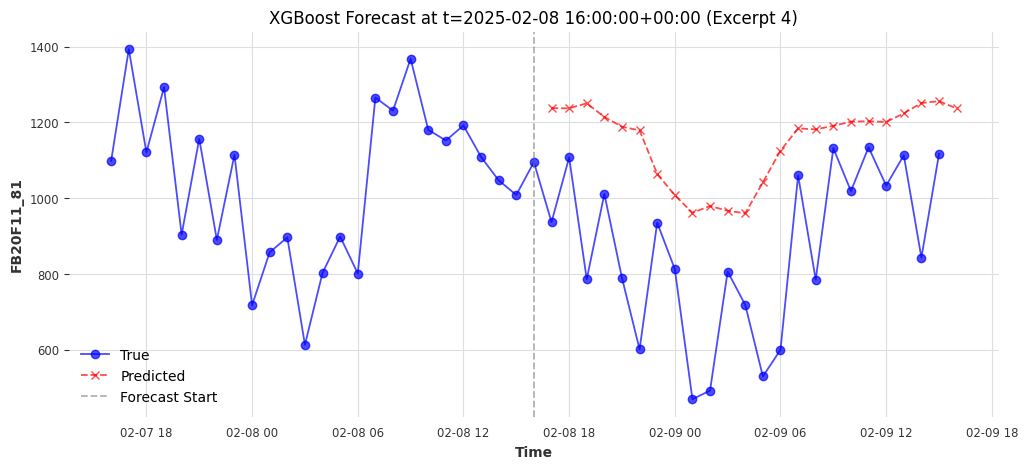

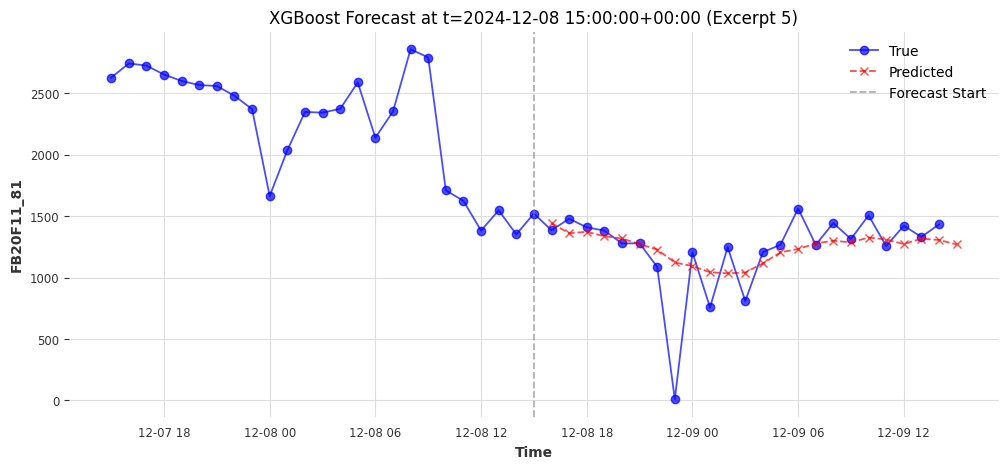

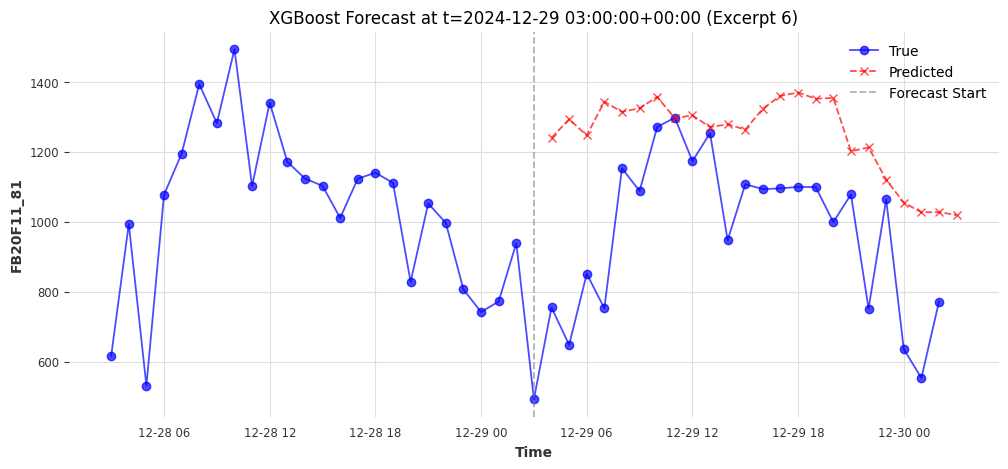

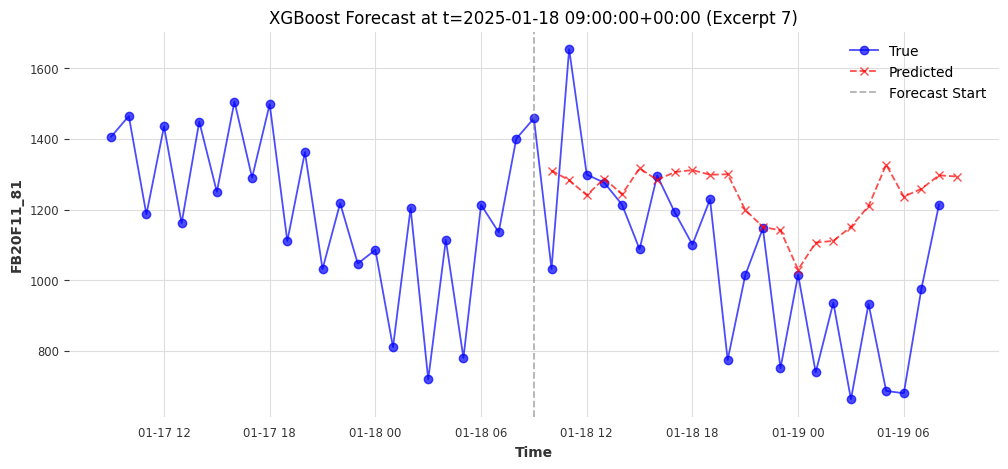

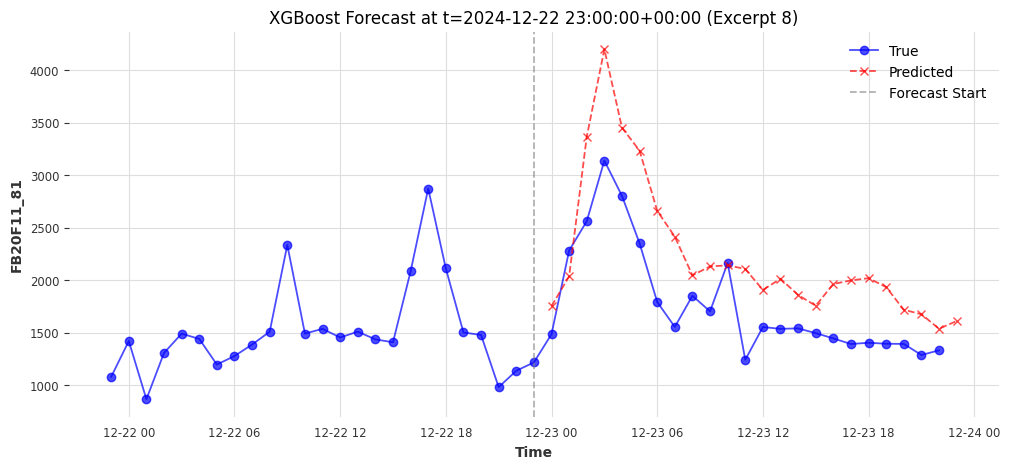

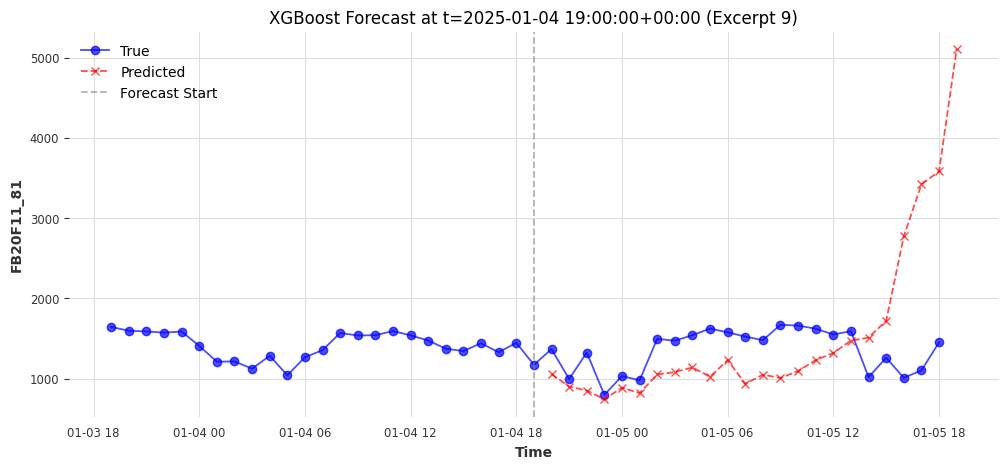

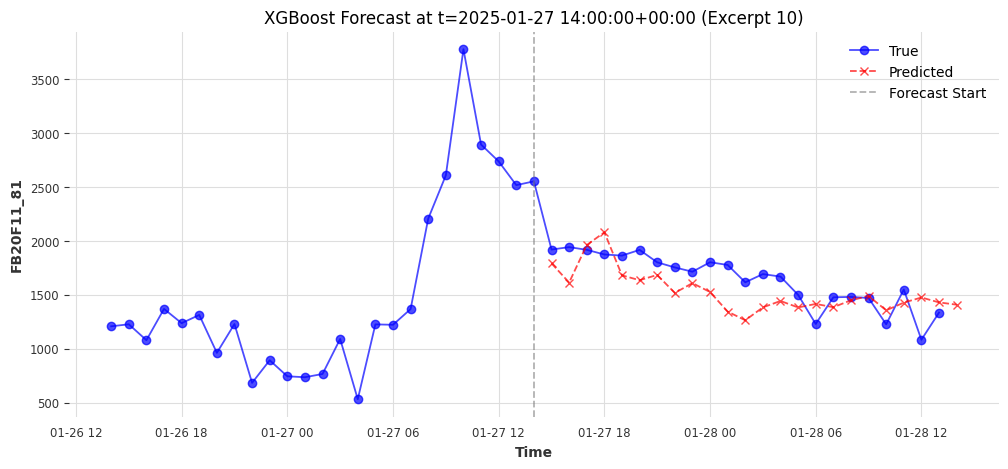

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

num_excerpts = 10

def find_high_value_excerpt(y_test, threshold=4000):
    high_value_indices = np.where(y_test.max(axis=1) > threshold)[0]
    if len(high_value_indices) > 0:
        return np.random.choice(high_value_indices)
    return np.random.randint(0, y_test.shape[0] - forecast_horizon)

for i in range(num_excerpts):
    if i == 0:  
        random_idx = find_high_value_excerpt(y_test)
    else:
        random_idx = np.random.randint(0, y_test.shape[0] - forecast_horizon)

    base_time = y_test.index[random_idx]

    plt.figure(figsize=(12, 5))

    context_range = np.arange(-forecast_horizon, forecast_horizon )
    time_steps = base_time + pd.to_timedelta(context_range, unit="h")

    true_values_context = np.concatenate([
        y_test.iloc[random_idx - forecast_horizon, :forecast_horizon].values.flatten(),
        y_test.iloc[random_idx, :forecast_horizon].values.flatten()
    ])

    plt.plot(time_steps, true_values_context, label="True", color="blue", marker="o", alpha=0.7)

    predicted_values = y_pred[random_idx, :forecast_horizon].flatten()
    forecast_time_steps = base_time + pd.to_timedelta(range(1, forecast_horizon + 1), unit="h")
    plt.plot(forecast_time_steps, predicted_values, label="Predicted", color="red", linestyle="dashed", marker="x", alpha=0.7)

    plt.title(f"XGBoost Forecast at t={base_time} (Excerpt {i+1})")
    plt.xlabel("Time")
    plt.ylabel("FB20F11_81")
    plt.axvline(base_time, color="gray", linestyle="--", alpha=0.6, label="Forecast Start")
    plt.legend()
    plt.grid(True)

    plt.show()



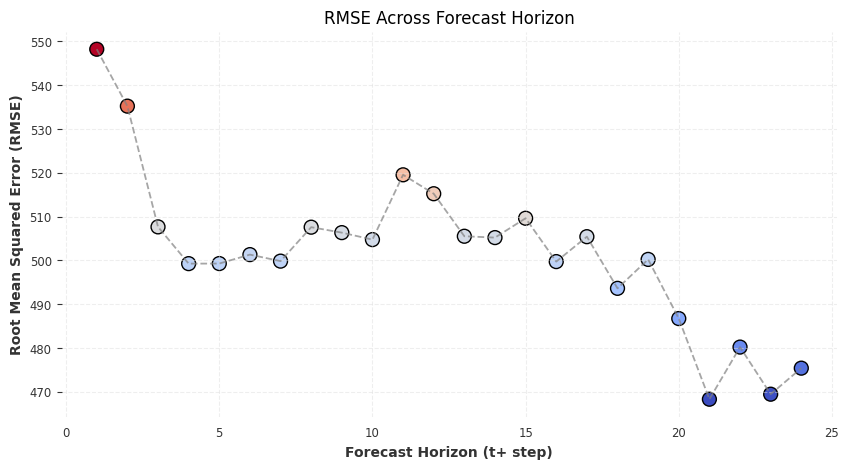

In [10]:
rmse_scores = np.sqrt([mean_squared_error(y_test.iloc[:, step], y_pred[:, step]) for step in range(forecast_horizon)])

steps = np.arange(1, forecast_horizon + 1)

plt.figure(figsize=(10, 5))
scatter = plt.scatter(steps, rmse_scores, c=rmse_scores, cmap='coolwarm', edgecolors='black', s=100)

plt.plot(steps, rmse_scores, linestyle='--', color='gray', alpha=0.7)

plt.xlabel("Forecast Horizon (t+ step)")
plt.ylabel("Root Mean Squared Error (RMSE)")
plt.title("RMSE Across Forecast Horizon")
plt.grid(True, linestyle="--", alpha=0.5)

plt.show()


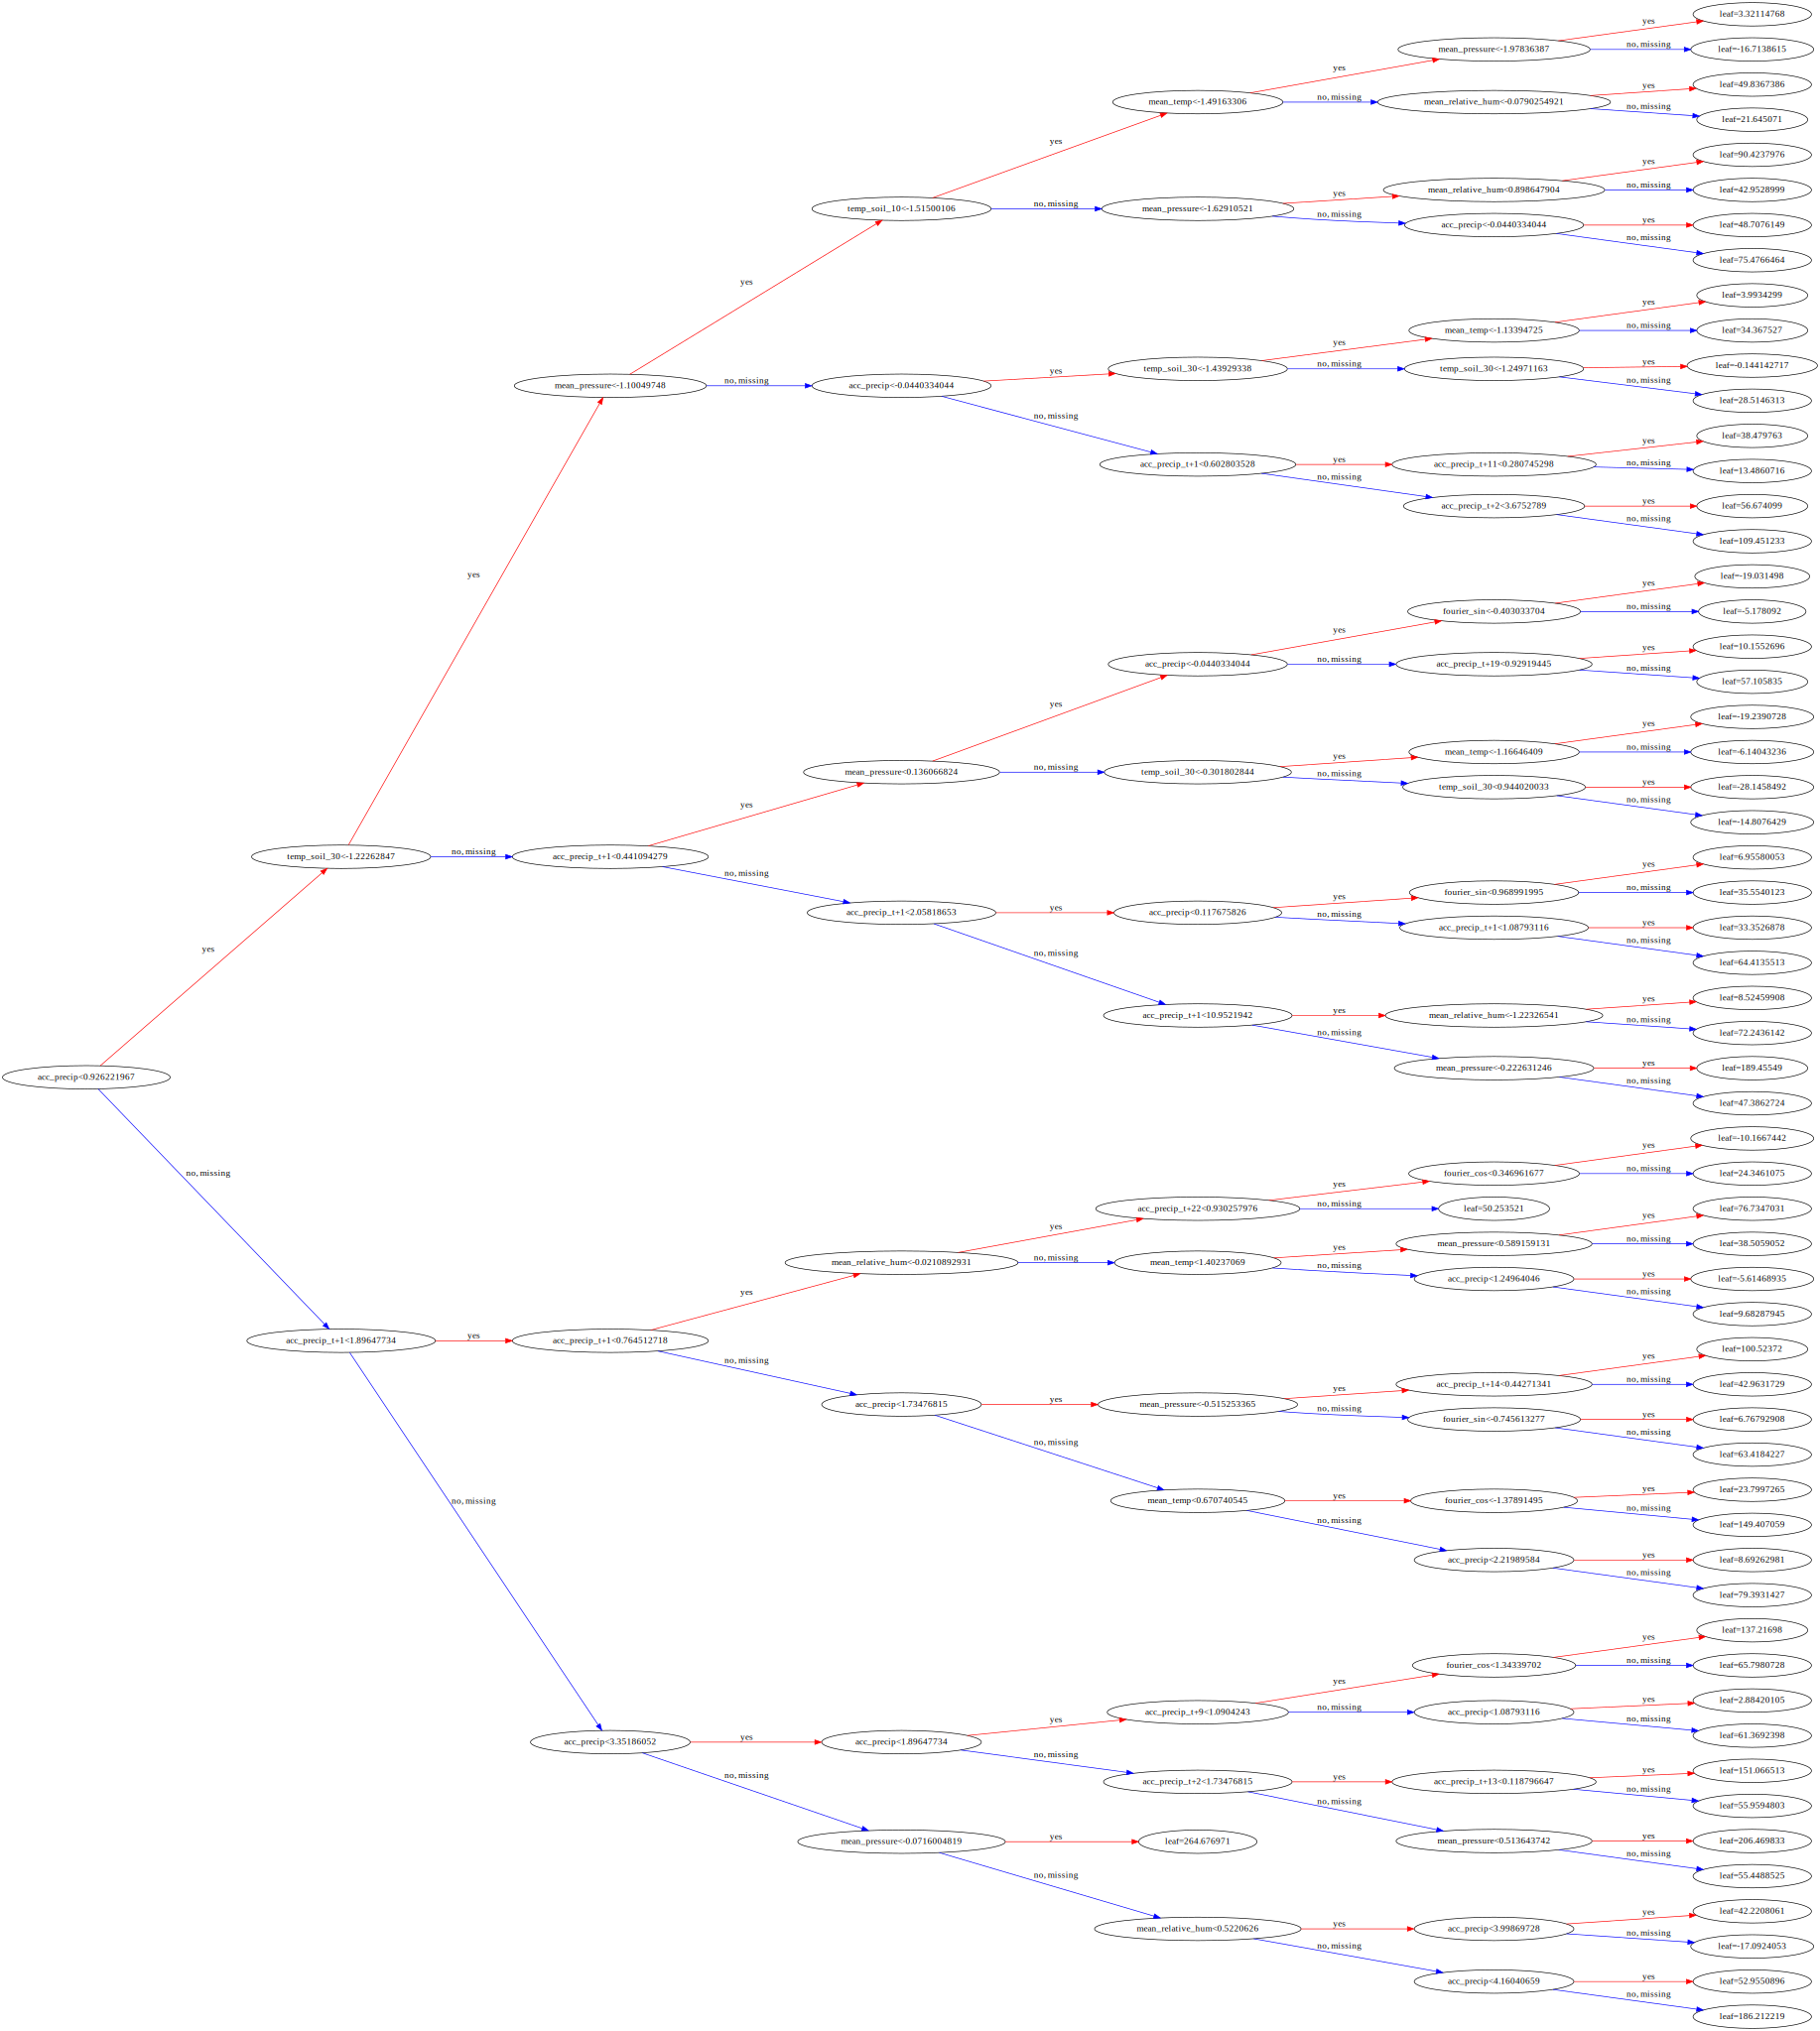

In [21]:
import graphviz

# Generate the tree in GraphViz format
dot_data = xgb.to_graphviz(xgb_model, num_trees=0, rankdir='LR')

# Save as a high-resolution vector file
dot_data.render('xgboost_tree', format='svg')

# Display the vector image
from IPython.display import display, SVG
display(SVG('xgboost_tree.svg'))

